# Imports and Configuration

In [44]:
import numpy as np
import cv2
import os
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from Week2_25100190_25100334 import (
    load_images_from_folder,
    compute_intrinsics_for_image,
    extract_colors,
)


In [ ]:
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #converting to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) #improving loval contrast
    equalized = clahe.apply(gray) 
    blurred = cv2.GaussianBlur(equalized, (3,3), 0) #blurring

    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, kernel)
    return sharpened

def visualize_map(sfm_map, percentile=95):
    if len(sfm_map.points3D) == 0: 
        print("No 3D points in map yet.")
        return

    pts = np.vstack(sfm_map.points3D)  #combining all 3d points

    
    if len(sfm_map.colors) == len(sfm_map.points3D):
        cols = np.vstack(sfm_map.colors) 
    else:
        cols = np.ones_like(pts) * 0.5

    #removing far-out points based on distance from center 
    centroid = pts.mean(axis=0)
    dists = np.linalg.norm(pts - centroid, axis=1)
    thr = np.percentile(dists, percentile)
    mask = dists <= thr
    pts = pts[mask]
    cols = cols[mask]

    X, Y, Z = pts[:, 0], pts[:, 1], pts[:, 2]

    fig = plt.figure(figsize=(18, 12))
    fig.patch.set_facecolor("white")

    
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(X, Y, Z, s=3, c=cols)
    ax1.set_title("3D View (RGB)")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    
    ax2 = fig.add_subplot(132)
    ax2.scatter(X, -Y, s=3, c=cols)
    ax2.set_title("Top View (X–Y)")
    ax2.set_aspect('equal', 'box')

    
    ax3 = fig.add_subplot(133)
    ax3.scatter(X, Z, s=3, c=cols)
    ax3.set_title("Side View (X–Z)")
    ax3.set_aspect('equal', 'box')

    plt.tight_layout()
    plt.show()


#  SIFT + FLANN matchers

In [ ]:
sift = cv2.SIFT_create() #sift feature extractor

def get_kp_desc(img, preprocess=True): #grayscale if not preprocessed
    if preprocess:
        gray = preprocess_image(img)
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, desc = sift.detectAndCompute(gray, None) #detecting keypoints and descriptors
    return kp, desc

#FLANN parameters
FLANN_INDEX_KDTREE = 1
flann = cv2.FlannBasedMatcher(
    dict(algorithm=FLANN_INDEX_KDTREE, trees=5),
    dict(checks=50)
)

def match_desc(desc1, desc2, ratio=0.7):

    if desc1 is None or desc2 is None: #no descriptor found
        return []

    matches = flann.knnMatch(desc1, desc2, k=2) #nearest two matches for each descriptor 
    good = []
    for m, n in matches: #applying Lowe's ratio for reliable results
        if m.distance < ratio * n.distance:
            good.append(m)
    return good


# SfM Map Data Structure

In [ ]:
class SfMMap:

    def __init__(self, K):
        self.K = K

        
        self.points3D = []             
        self.colors   = []             

        self.observations = {}
        self.kp   = {}                
        self.desc = {}                 
        self.camera_poses = {}

        self.kp_to_3D = {}             


# Triangulate

In [ ]:
def triangulate_and_filter(
    K,
    R_i, t_i,
    R_k, t_k,
    pts_i, pts_k,
    min_depth=0.3,
    max_depth=2000.0,
    reproj_thresh=50.0,
    min_angle_deg=0.3
):

    #return early if no matches
    if pts_i.shape[0] == 0:
        return np.empty((0, 3), dtype=np.float32), np.empty((0, 2)), np.empty((0, 2))

    #building projection matrices for both views 
    P_i = K @ np.hstack((R_i, t_i))
    P_k = K @ np.hstack((R_k, t_k))

    #Triangulating 3d points
    pts4D = cv2.triangulatePoints(P_i, P_k, pts_i.T, pts_k.T)
    X = (pts4D[:3] / pts4D[3]).T  

    #computing depth in each camera
    X_i_cam = (R_i @ X.T + t_i).T
    X_k_cam = (R_k @ X.T + t_k).T
    z_i = X_i_cam[:, 2]
    z_k = X_k_cam[:, 2]

    #keeping only valid positive
    depth_mask = (
        (z_i > min_depth) & (z_k > min_depth) &
        (z_i < max_depth) & (z_k < max_depth)
    )
    if depth_mask.sum() == 0:
        return np.empty((0, 3), dtype=np.float32), np.empty((0, 2)), np.empty((0, 2))

    #filtering by depth
    X = X[depth_mask]
    pts_i_f = pts_i[depth_mask]
    pts_k_f = pts_k[depth_mask]
    X_i_cam = X_i_cam[depth_mask]
    X_k_cam = X_k_cam[depth_mask]

    #camera centers
    C_i = -R_i.T @ t_i  
    C_k = -R_k.T @ t_k

    #computing viewing directions
    v_i = X - C_i.reshape(1, 3)
    v_k = X - C_k.reshape(1, 3)
    v_i_n = v_i / np.linalg.norm(v_i, axis=1, keepdims=True)
    v_k_n = v_k / np.linalg.norm(v_k, axis=1, keepdims=True)

    ##computing angle between rays
    cosang = np.sum(v_i_n * v_k_n, axis=1)
    ang = np.arccos(np.clip(cosang, -1.0, 1.0))
    min_angle = np.deg2rad(min_angle_deg)

    #filtering points with very small triangulation error 
    angle_mask = ang > min_angle

    if angle_mask.sum() > 0.5 * X.shape[0]:
        X = X[angle_mask]
        pts_i_f = pts_i_f[angle_mask]
        pts_k_f = pts_k_f[angle_mask]

    #checking if anything remains
    if X.shape[0] == 0:
        return np.empty((0, 3), dtype=np.float32), np.empty((0, 2)), np.empty((0, 2))

    #reprojecting points to both views 
    homog = np.hstack((X, np.ones((X.shape[0], 1), dtype=np.float64)))  

    proj_i = (P_i @ homog.T)
    proj_i = (proj_i[:2] / proj_i[2]).T  

    proj_k = (P_k @ homog.T)
    proj_k = (proj_k[:2] / proj_k[2]).T  

    #computing reprojection error 
    err_i = np.linalg.norm(proj_i - pts_i_f, axis=1)
    err_k = np.linalg.norm(proj_k - pts_k_f, axis=1)
    err = 0.5 * (err_i + err_k)

    #keeping points with low projection 
    reproj_mask = err < reproj_thresh

    X_final = X[reproj_mask]
    pts_i_final = pts_i_f[reproj_mask]
    pts_k_final = pts_k_f[reproj_mask]

    return X_final.astype(np.float32), pts_i_final.astype(np.float32), pts_k_final.astype(np.float32)



# SfM System Class

In [ ]:
class SfMSystem:
    def __init__(self, images, paths, K, preprocess=True):
        self.images = images
        self.paths  = paths
        self.K      = K
        self.preprocess = preprocess
        self.map    = SfMMap(K)


    def extract_features(self):
        print("[INFO] Extracting SIFT descriptors...")
        for i, img in enumerate(self.images):
            kp, desc = get_kp_desc(img, preprocess=self.preprocess) #getting keypoints and descriptors for each image
            self.map.kp[i]   = kp
            self.map.desc[i] = desc
            self.map.kp_to_3D[i] = {}
        print(f"[INFO] Features extracted for {len(self.images)} images.")


    def _compute_overlap_and_parallax(self, kp_i, kp_j, matches):
        if len(matches) == 0: #for no matches
            return 0.0, 0.0

        overlap = len(matches) / max(len(kp_i), len(kp_j), 1) #ratio of matches to keypoints

        #computing avg motion between corresponding points
        pts_i = np.float32([kp_i[m.queryIdx].pt for m in matches])
        pts_j = np.float32([kp_j[m.trainIdx].pt for m in matches])
        parallax = np.linalg.norm(pts_i - pts_j, axis=1).mean()
        return overlap, parallax


    def initialize_from_pair(self, i, j, ransac_thresh=1.0, min_inliers=60, triang_reproj_thresh=80.0):
        print(f"[INFO] Initializing from base pair ({i}, {j})")
       
        #loading keypoints and decriptors
        kp_i, desc_i = self.map.kp[i], self.map.desc[i]
        kp_j, desc_j = self.map.kp[j], self.map.desc[j]


        matches = match_desc(desc_i, desc_j) #matching descriptors 

        #estimating overlap and motion between views 
        overlap, parallax = self._compute_overlap_and_parallax(kp_i, kp_j, matches) 
        print(f"[INIT] matches={len(matches)}, overlap={overlap*100:.1f}%, avg parallax={parallax:.2f}px")

        if len(matches) < min_inliers:
            print(f"[INIT] Warning: very few matches for base pair ({i},{j}).")

        #collecting matching points
        pts_i = np.float32([kp_i[m.queryIdx].pt for m in matches])
        pts_j = np.float32([kp_j[m.trainIdx].pt for m in matches])

        #essential matrix
        E, maskE = cv2.findEssentialMat(
            pts_i, pts_j, self.K,
            method=cv2.RANSAC,
            prob=0.999,
            threshold=ransac_thresh
        )
        
        inl = maskE.ravel().astype(bool)
        num_inl = inl.sum()
        print(f"[INIT] inliers after E-RANSAC: {num_inl}")

        if num_inl < min_inliers:
            print(f"[INIT] Warning: only {num_inl} inliers after E-RANSAC.")

        #we will only keep inliers
        pts_i_inl = pts_i[inl]
        pts_j_inl = pts_j[inl]
        matches_inl = [m for m, v in zip(matches, inl) if v]

        #recovering relative pose 
        _, R, t, _ = cv2.recoverPose(E, pts_i_inl, pts_j_inl, self.K)
        print("[INFO] Base relative pose recovered.")

        #setting first camera as reference 
        self.map.camera_poses[i] = (np.eye(3, dtype=np.float64), np.zeros((3, 1), dtype=np.float64))
        self.map.camera_poses[j] = (R.astype(np.float64), t.astype(np.float64))


        #triangulating initial 3d points
        pts3D, pts_i_final, pts_j_final = triangulate_and_filter(
            self.K,
            self.map.camera_poses[i][0], self.map.camera_poses[i][1],
            self.map.camera_poses[j][0], self.map.camera_poses[j][1],
            pts_i_inl,
            pts_j_inl,
            reproj_thresh=triang_reproj_thresh
        )

        valid_count = pts3D.shape[0]
        print(f"[INIT] Triangulated {valid_count} valid points from base pair.")

       
        #building ampping from keypoints
        pts_i_inl_list = [kp_i[m.queryIdx].pt for m in matches_inl]
        pts_i_inl_arr = np.float32(pts_i_inl_list)

        for p3d, (u_i, v_i), (u_j, v_j) in zip(pts3D, pts_i_final, pts_j_final):
            #finding nearest inlier for association
            dists = np.linalg.norm(pts_i_inl_arr - np.array([[u_i, v_i]], dtype=np.float32), axis=1)
            idx = int(np.argmin(dists))
            m = matches_inl[idx]

            pid = len(self.map.points3D)
            self.map.points3D.append(p3d)

            c = extract_colors(self.images[i], np.array([[u_i, v_i]], dtype=np.float32))[0] #extracting color from image
            self.map.colors.append(c) 
            #storing where this 3d point was seen
            self.map.observations[pid] = {
                i: (float(u_i), float(v_i)),
                j: (float(u_j), float(v_j)),
            }

            qi = m.queryIdx
            tj = m.trainIdx
            self.map.kp_to_3D[i][qi] = pid
            self.map.kp_to_3D[j][tj] = pid

        print(f"[INFO] Base map initialized with {len(self.map.points3D)} points.")

    def _build_2d3d_correspondences(self, k):
        kp_k = self.map.kp[k]
        desc_k = self.map.desc[k]

        pts3D = []
        pts2D = []
        pids  = []
        kpidx = []

        #matching this view to all previous views
        for i, (R_i, t_i) in self.map.camera_poses.items():
            if i == k:
                continue

            kp_i   = self.map.kp[i]
            desc_i = self.map.desc[i]
            kp2p   = self.map.kp_to_3D[i]

            matches = match_desc(desc_i, desc_k)

            #for each match checking if the 3d point exists
            for m in matches:
                qi = m.queryIdx
                tk = m.trainIdx

                if qi not in kp2p:
                    continue  

                pid = kp2p[qi]
                pts3D.append(self.map.points3D[pid])
                pts2D.append(kp_k[tk].pt)
                pids.append(pid)
                kpidx.append(tk)

        if len(pts3D) == 0:
            return None, None, None, None

        pts3D = np.array(pts3D, dtype=np.float32)
        pts2D = np.array(pts2D, dtype=np.float32)
        return pts3D, pts2D, np.array(pids, dtype=np.int64), np.array(kpidx, dtype=np.int64)


    def add_view(self, k,
                 min_corrs=30,
                 min_inliers=30,
                 pnp_reproj_err=60.0):
        print(f"[INFO] Adding new view: image {k}")

        pts3D, pts2D, pids, kpidx = self._build_2d3d_correspondences(k)

        if pts3D is None or len(pts3D) < min_corrs:
            cnt = 0 if pts3D is None else len(pts3D)
            print(f"[WARN] Not enough 2D–3D correspondences for view {k} ({cnt})")
            return False

        print(f"[ADD_VIEW] view {k}: found {len(pts3D)} 2D–3D correspondences")

        ok, rvec, tvec, inliers = cv2.solvePnPRansac(
            pts3D, pts2D, self.K, None,
            reprojectionError=pnp_reproj_err,
            flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not ok or inliers is None:
            print(f"[ERROR] solvePnPRansac failed for view {k}")
            return False

        inliers = inliers.ravel()
        num_inl = len(inliers)
        ratio = num_inl / len(pts3D)

        if num_inl < min_inliers:
            print(f"[WARN] Weak PnP for view {k}: inliers={num_inl}, ratio={ratio:.2f}")
            

        R, _ = cv2.Rodrigues(rvec)
        t = tvec.reshape(3, 1)
        self.map.camera_poses[k] = (R.astype(np.float64), t.astype(np.float64))

        #updating according to inlier observations
        kp2p_k = self.map.kp_to_3D[k]
        for idx in inliers:
            pid   = int(pids[idx])
            u, v  = pts2D[idx]
            kp_id = int(kpidx[idx])

            
            if pid not in self.map.observations:
                self.map.observations[pid] = {}
            self.map.observations[pid][k] = (float(u), float(v))

            
            if kp_id not in kp2p_k:
                kp2p_k[kp_id] = pid

        print(f"[INFO] View {k} added with {num_inl} inliers")
        return True

    def _triangulate_between_views(self, i, k, min_matches=20, triang_reproj_thresh=80.0):
        #skipping identical points
        if i == k:
            return
        if i not in self.map.camera_poses or k not in self.map.camera_poses:
            return

        #posese and features
        Ri, ti = self.map.camera_poses[i]
        Rk, tk = self.map.camera_poses[k]

        kp_i, desc_i = self.map.kp[i], self.map.desc[i]
        kp_k, desc_k = self.map.kp[k], self.map.desc[k]
        kp2p_i = self.map.kp_to_3D[i]
        kp2p_k = self.map.kp_to_3D[k]

        #matches
        matches = match_desc(desc_i, desc_k)
        if len(matches) < min_matches: 
            return

        pts_i_tr = []
        pts_k_tr = []
        kp_i_ids = []
        kp_k_ids = []


        for m in matches:
            qi = m.queryIdx
            tkp = m.trainIdx
            ui, vi = kp_i[qi].pt
            uk, vk = kp_k[tkp].pt

            pid_i = kp2p_i.get(qi, None)
            pid_k = kp2p_k.get(tkp, None)

       
            if pid_i is not None and pid_k is not None: #if both keypoints already have a 3d point 
                if pid_i == pid_k and k not in self.map.observations[pid_i]:
                    self.map.observations[pid_i][k] = (uk, vk)
                continue


            if pid_i is not None: #if only one side is known, linking them 
                self.map.observations[pid_i][k] = (uk, vk)
                kp2p_k[tkp] = pid_i
                continue

            if pid_k is not None:
                self.map.observations[pid_k][i] = (ui, vi)
                kp2p_i[qi] = pid_k
                continue

            #other wise marking for triangulation
            pts_i_tr.append([ui, vi])
            pts_k_tr.append([uk, vk])
            kp_i_ids.append(qi)
            kp_k_ids.append(tkp)

        if len(pts_i_tr) < min_matches:
            return

        #converting lists to arrays 
        pts_i_tr = np.array(pts_i_tr, dtype=np.float32)
        pts_k_tr = np.array(pts_k_tr, dtype=np.float32)
        kp_i_ids = np.array(kp_i_ids, dtype=np.int32)
        kp_k_ids = np.array(kp_k_ids, dtype=np.int32)

        #triangulating between views    
        pts3D, pts_i_f, pts_k_f = triangulate_and_filter(
            self.K,
            Ri, ti,
            Rk, tk,
            pts_i_tr,
            pts_k_tr,
            reproj_thresh=triang_reproj_thresh
        )

        if pts3D.shape[0] == 0:
            return


        added = 0

        #adding newly triangulated points to map
        for p, (ui, vi), (uk, vk) in zip(pts3D, pts_i_f, pts_k_f):
            diffs = pts_i_tr - np.array([[ui, vi]], dtype=np.float32)
            dists = np.linalg.norm(diffs, axis=1)
            idx = int(np.argmin(dists))

            qi = int(kp_i_ids[idx])
            tkp = int(kp_k_ids[idx])

         
            if qi in kp2p_i or tkp in kp2p_k: #skipping if already assigned
                continue

            pid = len(self.map.points3D)
            self.map.points3D.append(p)
            c = extract_colors(self.images[i], np.array([[ui, vi]], dtype=np.float32))[0]
            self.map.colors.append(c)
            self.map.observations[pid] = {
                i: (float(ui), float(vi)),
                k: (float(uk), float(vk)),
            }

            kp2p_i[qi] = pid
            kp2p_k[tkp] = pid
            added += 1

        if added > 0:
            print(f"[TRIANG] between views {i} and {k}: added {added} points")


    def triangulate_new_points(self, k):
        if k not in self.map.camera_poses: #only triangulate if pose exists
            return
        for i in sorted(self.map.camera_poses.keys()): 
            if i >= k:
                continue
            self._triangulate_between_views(i, k)
        print(f"[INFO] Total 3D points so far: {len(self.map.points3D)}")



# Bundle Adjustment and Reprojection Error


In [ ]:
from scipy.optimize import least_squares

def prune_bad_points(sfm_map, K, factor=5.0, min_obs=2): 
    #computing projection error for every 3d point

    errors = []   
    large_val = 1e9


    for pid, X in enumerate(sfm_map.points3D):
        X = np.asarray(X, dtype=np.float64).reshape(3,)  
        obs = sfm_map.observations.get(pid, {})

        #skipping points with v few observations
        if len(obs) < min_obs:
            errors.append((pid, large_val))
            continue

        err_sum = 0.0
        count = 0

        for img_id, (u_obs, v_obs) in obs.items():
            if img_id not in sfm_map.camera_poses:
                continue

            R, t = sfm_map.camera_poses[img_id]
            R = np.asarray(R, dtype=np.float64).reshape(3, 3)
            t = np.asarray(t, dtype=np.float64).reshape(3,)

            Xc = R @ X + t  # (3,)
            if Xc[2] <= 0: #negative depth means bad point
                err_sum += large_val
                count += 1
                continue
            
            #simple pinhole projection
            u_proj = K[0, 0] * Xc[0] / Xc[2] + K[0, 2]
            v_proj = K[1, 1] * Xc[1] / Xc[2] + K[1, 2]

            err = np.hypot(u_proj - u_obs, v_proj - v_obs)
            err_sum += err
            count += 1

        mean_err = err_sum / max(count, 1)
        errors.append((pid, mean_err))

    #using median as robust threshold 
    valid_errs = [e for (_, e) in errors if e < large_val * 0.5]
    if len(valid_errs) == 0:
        print("[PRUNE] No valid errors to compute median. Skipping pruning.")
        return

    med = np.median(valid_errs)
    thr = med * factor

    #building new cleaned structures
    old_to_new = {}
    new_points = []
    new_colors = []
    new_observations = {}

    kept = 0
    removed = 0

    for pid, e in errors:
        if e < thr:
            new_pid = len(new_points)
            old_to_new[pid] = new_pid
            new_points.append(sfm_map.points3D[pid])
            new_colors.append(sfm_map.colors[pid])
            kept += 1
        else:
            removed += 1

    #copying observations for points we keep
    for old_pid, new_pid in old_to_new.items():
        obs = sfm_map.observations.get(old_pid, {})
        if not obs:
            continue
        new_observations[new_pid] = dict(obs)  

    #updating kp to 3d mapping
    for img_id, kpmap in sfm_map.kp_to_3D.items():
        new_kpmap = {}
        for kp_idx, old_pid in kpmap.items():
            if old_pid in old_to_new:
                new_kpmap[kp_idx] = old_to_new[old_pid]
        sfm_map.kp_to_3D[img_id] = new_kpmap

    #replacing old data
    sfm_map.points3D = new_points
    sfm_map.colors   = new_colors
    sfm_map.observations = new_observations

    print(f"[PRUNE] Kept {kept} points, Removed {removed} points "
          f"(med={med:.3f}, thr={thr:.3f})")

def rodrigues_to_matrix(rvec):
    #converting roataion vector to matrix
    R, _ = cv2.Rodrigues(rvec.reshape(3, 1))
    return R

def matrix_to_rodrigues(R):
    #convert rotation matrix to rotation vector 
    rvec, _ = cv2.Rodrigues(R)
    return rvec.reshape(3)

def project_point(K, R, t, X):
    #applying camera model: x_world->image pixel 
    X = np.asarray(X, dtype=np.float64).reshape(3,)
    R = np.asarray(R, dtype=np.float64).reshape(3, 3)
    t = np.asarray(t, dtype=np.float64).reshape(3,)

    Xc = R @ X + t
    u = K[0, 0] * Xc[0] / Xc[2] + K[0, 2]
    v = K[1, 1] * Xc[1] / Xc[2] + K[1, 2]
    return u, v

def bundle_adjustment(map_data, K, verbose=True):
    #deciding which camera to optimise 
    cam_index = sorted(map_data.camera_poses.keys())
    if len(cam_index) < 2:
        if verbose:
            print("[BA] Not enough cameras for BA.")
        return

    ref_cam = cam_index[0]
    opt_cams = cam_index[1:]

    #keeping reference camera fixed 
    R_ref, t_ref = map_data.camera_poses[ref_cam]
    R_ref = R_ref.copy()
    t_ref = t_ref.copy()

    num_points = len(map_data.points3D)
    if num_points == 0:
        if verbose:
            print("[BA] No 3D points. Skipping BA.")
        return

    #flattening all camera parameters into 1 vector
    def pack_params():
        params = []
        for cid in opt_cams:
            R, t = map_data.camera_poses[cid]
            rvec = matrix_to_rodrigues(R)
            params.extend(rvec)
            params.extend(t.reshape(3))
        return np.array(params, dtype=np.float64)

    #concerting parameter vector back to pose dictionaries 
    def unpack_params(p):
        cameras = {}
        ptr = 0
        cameras[ref_cam] = (R_ref, t_ref)
        for cid in opt_cams:
            rvec = p[ptr:ptr+3]; ptr += 3
            tvec = p[ptr:ptr+3]; ptr += 3
            R = rodrigues_to_matrix(rvec)
            t = tvec.reshape(3, 1)
            cameras[cid] = (R, t)
        return cameras

    #computin reprojection residuals for all measurements
    def residuals(p):
        cameras = unpack_params(p)
        res = []

        for pid, obs in map_data.observations.items():
            X = np.array(map_data.points3D[pid], dtype=np.float64)
            for img_id, (u_obs, v_obs) in obs.items():
                if img_id not in cameras:
                    continue
                R, t = cameras[img_id]
                u_proj, v_proj = project_point(K, R, t, X)
                res.append(u_proj - u_obs)
                res.append(v_proj - v_obs)

        return np.array(res, dtype=np.float64)

    #initial parameter vector 
    p0 = pack_params()
    if verbose:
        print(f"[BA] Pose-only BA on {len(opt_cams)} cameras, {num_points} points")
        print(f"[BA] Parameter vector length: {len(p0)}")

    #running optimization 
    result = least_squares(
        residuals,
        p0,
        verbose=2 if verbose else 0,
        method="trf",
        loss="huber",
        xtol=1e-8,
        ftol=1e-8,
    )

    #updating optimized camera poses 
    cameras_opt = unpack_params(result.x)
    for cid, (R, t) in cameras_opt.items():
        map_data.camera_poses[cid] = (R, t)

    if verbose:
        print("[BA] Pose-only BA finished.")

#collecting errors for all onservations
def report_reprojection_error(map_data, K, label="[REPROJ]"):
    errors = []
    per_image = {}

    for pid, obs in map_data.observations.items():
        X = np.array(map_data.points3D[pid], dtype=np.float64)
        for img_id, (u_obs, v_obs) in obs.items():
            R, t = map_data.camera_poses[img_id]
            u_proj, v_proj = project_point(K, R, t, X)
            err = np.hypot(u_proj - u_obs, v_proj - v_obs)
            errors.append(err)
            per_image.setdefault(img_id, []).append(err)

    if len(errors) == 0:
        print(f"{label} No observations to report.")
        return

    errors = np.array(errors)
    print(f"{label} Global reprojection error (pixels):")
    print(f"  mean   = {errors.mean():.4f}")
    print(f"  median = {np.median(errors):.4f}")
    print(f"  max    = {errors.max():.4f}")

    for img_id in sorted(per_image.keys()):
        arr = np.array(per_image[img_id])
        print(f"{label}  Image {img_id}: mean={arr.mean():.3f}, "
              f"median={np.median(arr):.3f}, max={arr.max():.3f}")



# Main 

[EXIF] focal_35mm = 24.0
[EXIF] focal_mm   = 6.764999865652793
[EXIF] image size = 1500 × 1999
K =
 [[1000.     0.   750. ]
 [   0.  1000.   999.5]
 [   0.     0.     1. ]]
[INFO] Extracting SIFT descriptors...
[INFO] Features extracted for 24 images.
[INFO] Initializing from base pair (1, 2)
[INIT] matches=1454, overlap=3.5%, avg parallax=479.38px
[INIT] inliers after E-RANSAC: 700
[INFO] Base relative pose recovered.
[INIT] Triangulated 700 valid points from base pair.
[INFO] Base map initialized with 700 points.
[REPROJ BEFORE BA-INIT] Global reprojection error (pixels):
  mean   = 0.3456
  median = 0.3326
  max    = 0.9415
[REPROJ BEFORE BA-INIT]  Image 1: mean=0.281, median=0.279, max=0.630
[REPROJ BEFORE BA-INIT]  Image 2: mean=0.411, median=0.410, max=0.942
[BA] Pose-only BA on 1 cameras, 700 points
[BA] Parameter vector length: 6
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1820e+02                 

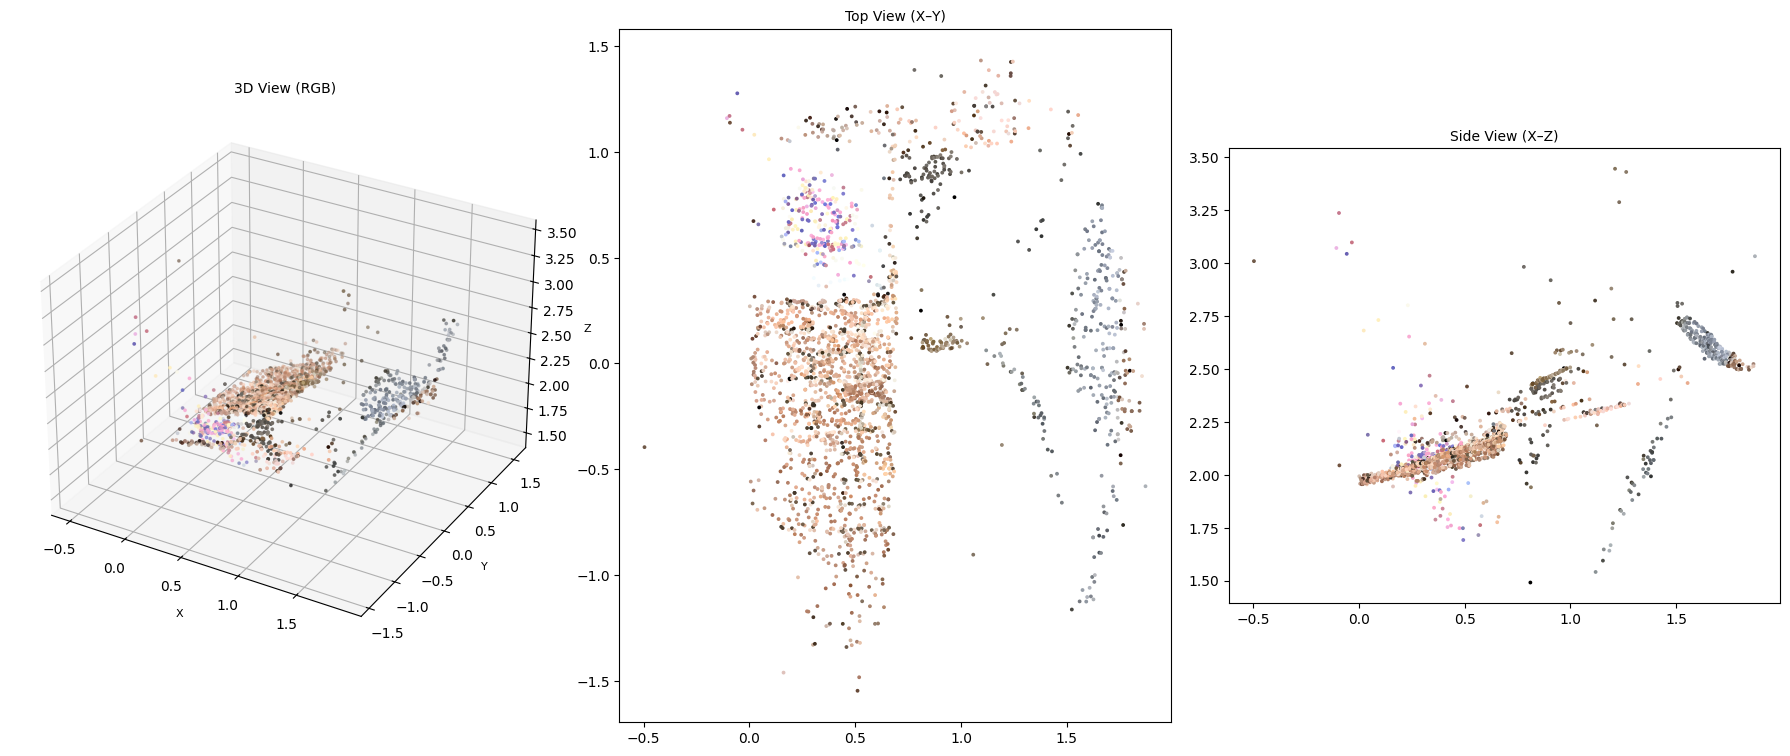

[INFO] Adding new view: image 6
[ADD_VIEW] view 6: found 1567 2D–3D correspondences
[INFO] View 6 added with 1380 inliers
[TRIANG] between views 1 and 6: added 748 points
[TRIANG] between views 2 and 6: added 611 points
[TRIANG] between views 3 and 6: added 266 points
[TRIANG] between views 4 and 6: added 258 points
[TRIANG] between views 5 and 6: added 203 points
[INFO] Total 3D points so far: 4794
[INFO] Adding new view: image 7
[ADD_VIEW] view 7: found 933 2D–3D correspondences
[INFO] View 7 added with 844 inliers
[TRIANG] between views 1 and 7: added 219 points
[TRIANG] between views 2 and 7: added 57 points
[TRIANG] between views 3 and 7: added 41 points
[TRIANG] between views 4 and 7: added 30 points
[TRIANG] between views 5 and 7: added 19 points
[TRIANG] between views 6 and 7: added 229 points
[INFO] Total 3D points so far: 5389
[INFO] Adding new view: image 8
[ADD_VIEW] view 8: found 83 2D–3D correspondences
[WARN] Weak PnP for view 8: inliers=22, ratio=0.27
[INFO] View 8 adde

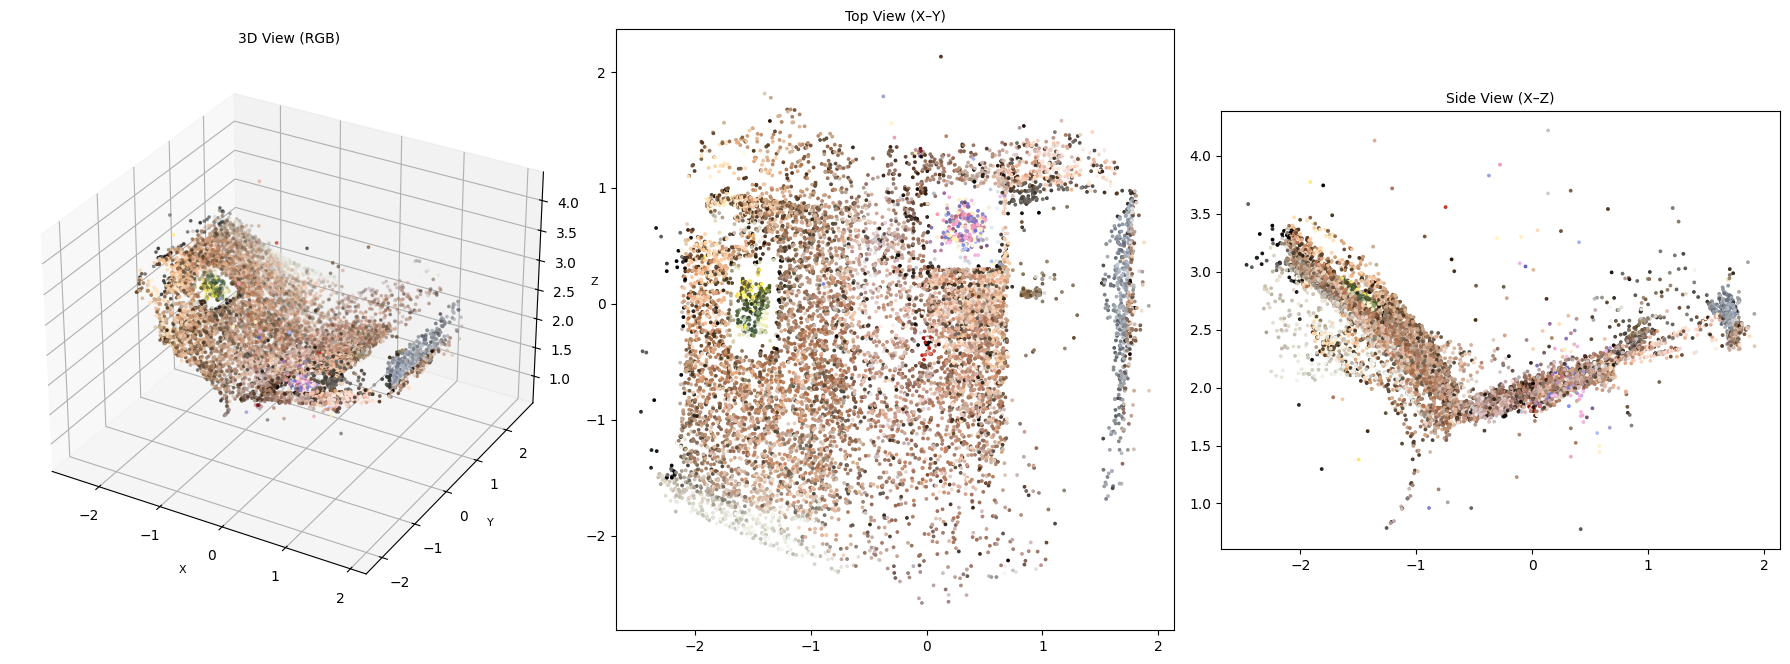

[INFO] Adding new view: image 11
[ADD_VIEW] view 11: found 794 2D–3D correspondences
[INFO] View 11 added with 354 inliers
[TRIANG] between views 1 and 11: added 10 points
[TRIANG] between views 2 and 11: added 7 points
[TRIANG] between views 3 and 11: added 6 points
[TRIANG] between views 4 and 11: added 13 points
[TRIANG] between views 5 and 11: added 3 points
[TRIANG] between views 6 and 11: added 6 points
[TRIANG] between views 7 and 11: added 5 points
[TRIANG] between views 8 and 11: added 90 points
[TRIANG] between views 9 and 11: added 89 points
[TRIANG] between views 10 and 11: added 1260 points
[INFO] Total 3D points so far: 13031
[INFO] Adding new view: image 12
[ADD_VIEW] view 12: found 1526 2D–3D correspondences
[INFO] View 12 added with 819 inliers
[TRIANG] between views 1 and 12: added 14 points
[TRIANG] between views 2 and 12: added 6 points
[TRIANG] between views 3 and 12: added 6 points
[TRIANG] between views 4 and 12: added 5 points
[TRIANG] between views 5 and 12: ad

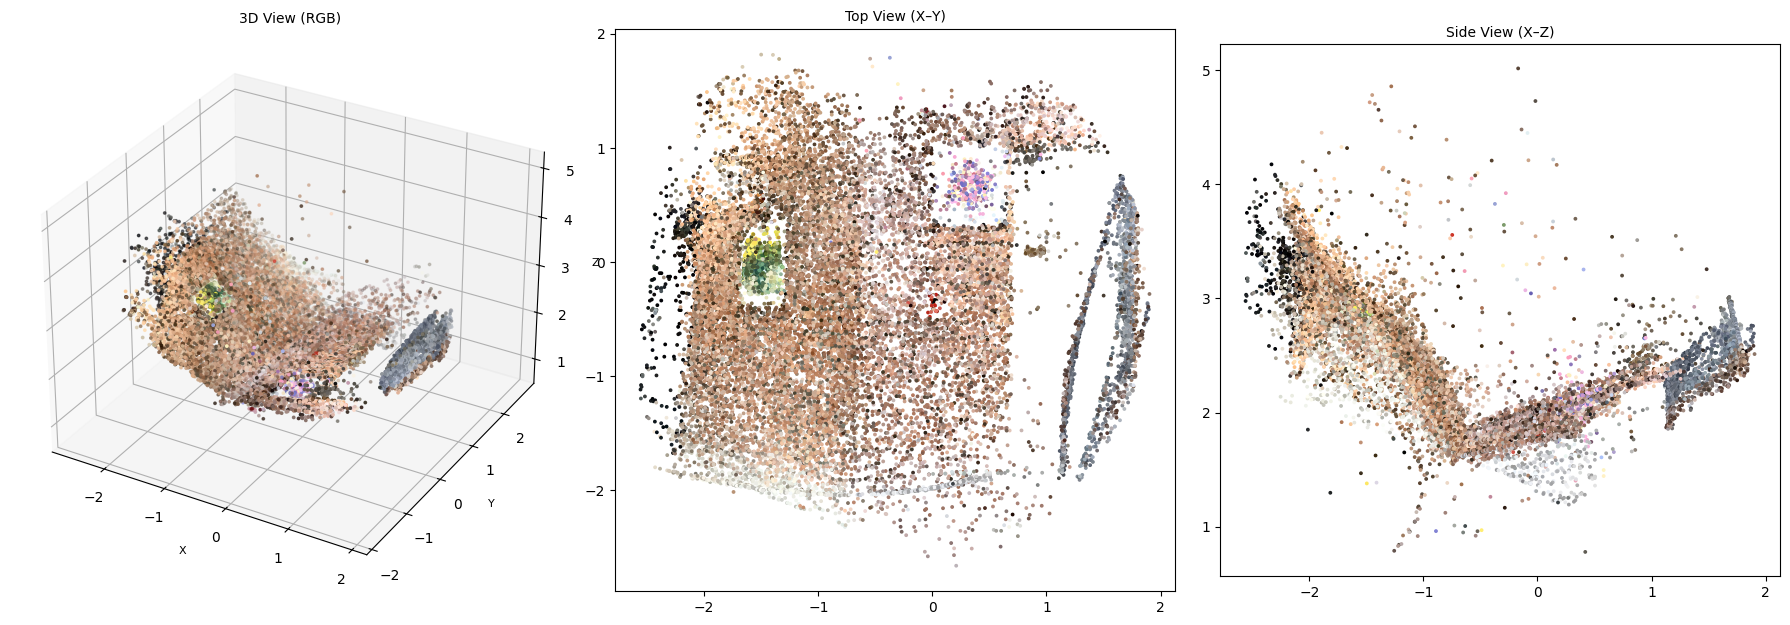

[INFO] Adding new view: image 16
[ADD_VIEW] view 16: found 3468 2D–3D correspondences
[INFO] View 16 added with 2538 inliers
[TRIANG] between views 1 and 16: added 1033 points
[TRIANG] between views 2 and 16: added 822 points
[TRIANG] between views 3 and 16: added 41 points
[TRIANG] between views 4 and 16: added 20 points
[TRIANG] between views 5 and 16: added 14 points
[TRIANG] between views 6 and 16: added 97 points
[TRIANG] between views 7 and 16: added 39 points
[TRIANG] between views 8 and 16: added 10 points
[TRIANG] between views 9 and 16: added 195 points
[TRIANG] between views 10 and 16: added 6 points
[TRIANG] between views 11 and 16: added 2 points
[TRIANG] between views 12 and 16: added 2 points
[TRIANG] between views 13 and 16: added 1 points
[TRIANG] between views 14 and 16: added 41 points
[TRIANG] between views 15 and 16: added 539 points
[INFO] Total 3D points so far: 28703
[INFO] Running periodic BA after adding view 16...
[REPROJ BEFORE BA @ 16] Global reprojection e

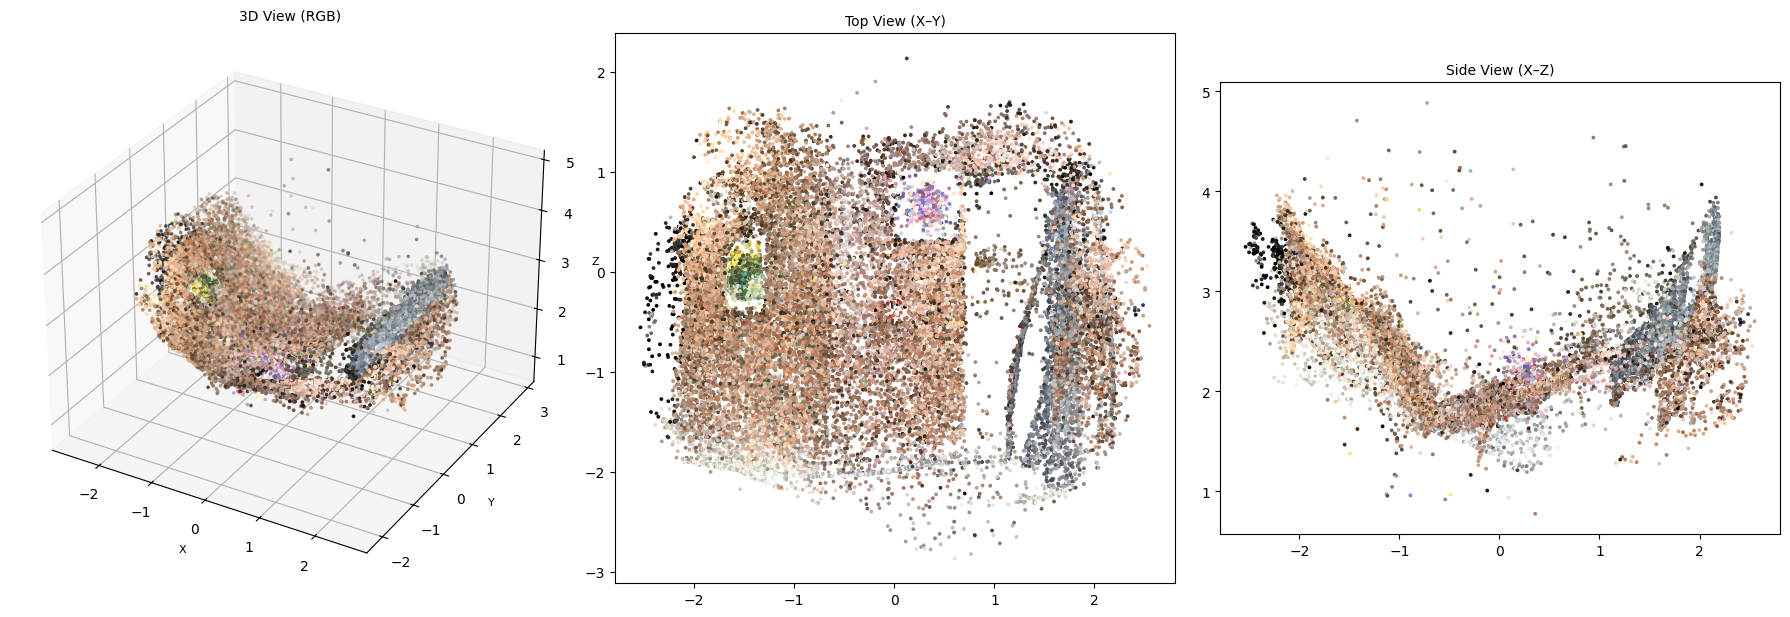

[INFO] Adding new view: image 21
[ADD_VIEW] view 21: found 1719 2D–3D correspondences
[INFO] View 21 added with 1500 inliers
[TRIANG] between views 1 and 21: added 74 points
[TRIANG] between views 2 and 21: added 29 points
[TRIANG] between views 3 and 21: added 21 points
[TRIANG] between views 4 and 21: added 21 points
[TRIANG] between views 5 and 21: added 19 points
[TRIANG] between views 6 and 21: added 57 points
[TRIANG] between views 7 and 21: added 487 points
[TRIANG] between views 8 and 21: added 9 points
[TRIANG] between views 9 and 21: added 14 points
[TRIANG] between views 10 and 21: added 15 points
[TRIANG] between views 11 and 21: added 5 points
[TRIANG] between views 12 and 21: added 3 points
[TRIANG] between views 13 and 21: added 9 points
[TRIANG] between views 14 and 21: added 7 points
[TRIANG] between views 15 and 21: added 19 points
[TRIANG] between views 16 and 21: added 31 points
[TRIANG] between views 18 and 21: added 2 points
[TRIANG] between views 20 and 21: added

In [ ]:
def run_week3_sfm(
    dataset_path="./Dataset/Option 1/",
    base_i=1,
    base_j=2,
    ba_interval=7
):
    #loading images from folder
    images, paths = load_images_from_folder("./Dataset/Option 1/", resize_width=1500)
    if len(images) < 2:
        raise RuntimeError("Need at least two images for SfM.")

    #computing intrinsics from exif and image size
    K = compute_intrinsics_for_image(
        paths[0],
        images[0].shape,
        resized_width=None
    )

    #creatinging sfm ssystem and extracting features
    sfm = SfMSystem(images, paths, K, preprocess=True)
    sfm.extract_features()

    #initialising map using a selected image pair 
    sfm.initialize_from_pair(base_i, base_j, ransac_thresh=1.0, min_inliers=60,triang_reproj_thresh=50.0)

    #checking reprojection error before and after initial bundle adjustment 
    report_reprojection_error(sfm.map, K, label="[REPROJ BEFORE BA-INIT]")
    bundle_adjustment(sfm.map, K, verbose=True)
    report_reprojection_error(sfm.map, K, label="[REPROJ AFTER BA-INIT]")

    #then adding images one by one
    images_added_since_ba = 0
    for k in range(base_j + 1, len(images)):
        added = sfm.add_view(k, min_corrs=30, min_inliers=30, pnp_reproj_err=40.0) #for new view
        if not added:
            continue
        
        #triangulating any new 3d points from this image 
        sfm.triangulate_new_points(k)

        #running periodic bundle adjustemnt every few images
        images_added_since_ba += 1
        if images_added_since_ba >= ba_interval:
            print(f"[INFO] Running periodic BA after adding view {k}...")
            report_reprojection_error(sfm.map, K, label=f"[REPROJ BEFORE BA @ {k}]")
            prune_bad_points(sfm.map, K, factor=7.0, min_obs=2)
            bundle_adjustment(sfm.map, K, verbose=False)
            report_reprojection_error(sfm.map, K, label=f"[REPROJ AFTER BA @ {k}]")
            images_added_since_ba = 0

        #to check visualisation 
        if k % 5 == 0:
            visualize_map(sfm.map)


    print("[INFO] Final bundle adjustment...")
    report_reprojection_error(sfm.map, K, label="[REPROJ BEFORE FINAL BA]")
    prune_bad_points(sfm.map, K, factor=7.0, min_obs=2)
    bundle_adjustment(sfm.map, K, verbose=True)
    report_reprojection_error(sfm.map, K, label="[REPROJ AFTER FINAL BA]")

    print("[INFO] Final 3D map: total points =", len(sfm.map.points3D))
    pts = np.array(sfm.map.points3D, dtype=np.float32)
    cols = np.array(sfm.map.colors, dtype=np.float32)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)
    
    if cols.size > 0:
        if cols.max() > 1.0:
            cols_use = cols / 255.0
        else:
            cols_use = cols
        pcd.colors = o3d.utility.Vector3dVector(cols_use)

    o3d.io.write_point_cloud("week3_cloud.ply", pcd)
    print("[DONE] Week 3 reconstruction saved → week3_cloud.ply")

if __name__ == "__main__":
    run_week3_sfm()